# Gmail RAG System with Gemini

## Gmail-powered Knowledge Assistant

This system will:
1. Connect to your Gmail account using Google APIs
2. Extract and process email content
3. Create a vector database from your emails
4. Use Gemini to answer questions based on your email history

### Prerequisites
- Google Cloud Project with Gmail API enabled
- OAuth 2.0 credentials downloaded as `credentials.json`
- Gemini API key in your `.env` file

In [1]:
# Gmail RAG System - Imports
import os
import pickle
import base64
import email
from datetime import datetime, timedelta
from dotenv import load_dotenv
import gradio as gr
import google.generativeai as genai
from googleapiclient.discovery import build
from google_auth_oauthlib.flow import InstalledAppFlow
from google.auth.transport.requests import Request

# LangChain imports with Google GenAI
from langchain.document_loaders import DirectoryLoader, TextLoader
from langchain.text_splitter import CharacterTextSplitter
from langchain.schema import Document
from langchain_chroma import Chroma
from langchain.memory import ConversationBufferMemory
from langchain.chains import ConversationalRetrievalChain

# Try Google GenAI LangChain integration with version checking
try:
    from langchain_google_genai import GoogleGenerativeAIEmbeddings, ChatGoogleGenerativeAI
    import google.ai.generativelanguage as genai_lang
    
    # Check version compatibility
    try:
        version = genai_lang.__version__
        print(f"✅ google-ai-generativelanguage version: {version}")
    except:
        print("✅ LangChain Google GenAI integration loaded")
    
    LANGCHAIN_GOOGLE_AVAILABLE = True
    print("✅ Using Gemini models")
except ImportError as e:
    print(f"❌ LangChain Google GenAI not available: {e}")
    print("📦 Try: pip install --upgrade google-ai-generativelanguage>=0.6.18")
    LANGCHAIN_GOOGLE_AVAILABLE = False
    # Fallback to OpenAI
    try:
        from langchain_openai import OpenAIEmbeddings, ChatOpenAI
        print("✅ Falling back to OpenAI models")
    except ImportError:
        print("❌ Neither Google GenAI nor OpenAI available. Please install one of them.")
        raise

# Visualization
import numpy as np
from sklearn.manifold import TSNE
import plotly.graph_objects as go
import re
from bs4 import BeautifulSoup

✅ google-ai-generativelanguage version: 0.6.18
✅ Using Gemini models


In [2]:
# Configuration with better error handling
SCOPES = ['https://www.googleapis.com/auth/gmail.readonly']

# Choose model based on available integrations
if LANGCHAIN_GOOGLE_AVAILABLE:
    MODEL = "gemini-1.5-flash"
    EMBEDDING_MODEL = "models/embedding-001"
    print("🤖 Configuration: Gemini models")
else:
    MODEL = "gpt-4o-mini" 
    EMBEDDING_MODEL = "text-embedding-ada-002"
    print("🤖 Configuration: OpenAI models (fallback)")

DB_NAME = "gmail_vector_db"
MAX_EMAILS = 500

🤖 Configuration: Gemini models


In [3]:
# Load environment variables with validation
load_dotenv()
os.environ['GOOGLE_API_KEY'] = os.getenv('GOOGLE_API_KEY', 'your-key-if-not-using-env')

# Validate API keys
google_key = os.environ['GOOGLE_API_KEY']
if LANGCHAIN_GOOGLE_AVAILABLE:
    if google_key == 'your-key-if-not-using-env' or not google_key:
        print("⚠️  Warning: Google API key not found. Please set GOOGLE_API_KEY in .env file")
    else:
        genai.configure()
        print("✅ Google API configured")
else:
    os.environ['OPENAI_API_KEY'] = os.getenv('OPENAI_API_KEY', 'your-key-if-not-using-env')
    openai_key = os.environ['OPENAI_API_KEY']
    if openai_key == 'your-key-if-not-using-env' or not openai_key:
        print("⚠️  Warning: OpenAI API key not found. Please set OPENAI_API_KEY in .env file")
    else:
        print("✅ OpenAI API configured")

✅ Google API configured


In [4]:
class GmailExtractor:
    """Gmail API handler for extracting emails"""
    
    def __init__(self, credentials_file='credentials.json', token_file='token.pickle'):
        self.credentials_file = credentials_file
        self.token_file = token_file
        self.service = None
        self.authenticate()
    
    def authenticate(self):
        """Authenticate with Gmail API"""
        creds = None
        
        # Load existing token
        if os.path.exists(self.token_file):
            with open(self.token_file, 'rb') as token:
                creds = pickle.load(token)
        
        # If no valid credentials, get new ones
        if not creds or not creds.valid:
            if creds and creds.expired and creds.refresh_token:
                creds.refresh(Request())
            else:
                if not os.path.exists(self.credentials_file):
                    raise FileNotFoundError(
                        f"Please download your Gmail API credentials as '{self.credentials_file}' "
                        "from Google Cloud Console"
                    )
                flow = InstalledAppFlow.from_client_secrets_file(
                    self.credentials_file, SCOPES)
                creds = flow.run_local_server(port=0)
            
            # Save credentials for next run
            with open(self.token_file, 'wb') as token:
                pickle.dump(creds, token)
        
        self.service = build('gmail', 'v1', credentials=creds)
        print("Gmail authentication successful!")
    
    def get_message_content(self, message_id):
        """Extract content from a Gmail message"""
        try:
            message = self.service.users().messages().get(
                userId='me', id=message_id, format='full'
            ).execute()
            
            # Extract headers
            headers = message['payload'].get('headers', [])
            subject = next((h['value'] for h in headers if h['name'] == 'Subject'), 'No Subject')
            sender = next((h['value'] for h in headers if h['name'] == 'From'), 'Unknown Sender')
            date = next((h['value'] for h in headers if h['name'] == 'Date'), 'Unknown Date')
            
            # Extract body
            body = self._extract_body(message['payload'])
            
            return {
                'id': message_id,
                'subject': subject,
                'sender': sender,
                'date': date,
                'body': body
            }
        except Exception as e:
            print(f"Error extracting message {message_id}: {e}")
            return None
    
    def _extract_body(self, payload):
        """Extract body text from email payload"""
        body = ""
        
        if 'parts' in payload:
            for part in payload['parts']:
                if part['mimeType'] == 'text/plain':
                    data = part['body']['data']
                    body += base64.urlsafe_b64decode(data).decode('utf-8')
                elif part['mimeType'] == 'text/html':
                    data = part['body']['data']
                    html_content = base64.urlsafe_b64decode(data).decode('utf-8')
                    # Convert HTML to plain text
                    soup = BeautifulSoup(html_content, 'html.parser')
                    body += soup.get_text()
        else:
            if payload['mimeType'] == 'text/plain':
                data = payload['body']['data']
                body = base64.urlsafe_b64decode(data).decode('utf-8')
            elif payload['mimeType'] == 'text/html':
                data = payload['body']['data']
                html_content = base64.urlsafe_b64decode(data).decode('utf-8')
                soup = BeautifulSoup(html_content, 'html.parser')
                body = soup.get_text()
        
        return body.strip()
    
    def get_emails(self, max_results=MAX_EMAILS, query=''):
        """Get emails from Gmail"""
        try:
            # Get message IDs
            results = self.service.users().messages().list(
                userId='me', maxResults=max_results, q=query
            ).execute()
            
            messages = results.get('messages', [])
            print(f"Found {len(messages)} emails to process...")
            
            emails = []
            for i, msg in enumerate(messages):
                if i % 50 == 0:
                    print(f"Processing email {i+1}/{len(messages)}")
                
                email_content = self.get_message_content(msg['id'])
                if email_content and email_content['body']:
                    emails.append(email_content)
            
            print(f"Successfully extracted {len(emails)} emails")
            return emails
            
        except Exception as e:
            print(f"Error getting emails: {e}")
            return []

In [5]:
class EmailDocument:
    """Document class for email content"""
    
    def __init__(self, email_data):
        self.metadata = {
            'source': f"Gmail - {email_data['id']}",
            'subject': email_data['subject'],
            'sender': email_data['sender'],
            'date': email_data['date'],
            'doc_type': 'email'
        }
        
        # Combine subject and body for content
        self.page_content = f"Subject: {email_data['subject']}\n"
        self.page_content += f"From: {email_data['sender']}\n"
        self.page_content += f"Date: {email_data['date']}\n\n"
        self.page_content += email_data['body']
        
        # Clean up the content
        self.page_content = self._clean_content(self.page_content)
    
    def _clean_content(self, content):
        """Clean email content"""
        # Remove excessive whitespace
        content = re.sub(r'\n\s*\n', '\n\n', content)
        content = re.sub(r'\s+', ' ', content)
        
        # Remove common email artifacts
        content = re.sub(r'(On .* wrote:)', '', content)
        content = re.sub(r'(From: .*\nSent: .*\nTo: .*\nSubject: .*)', '', content)
        
        return content.strip()

In [6]:
def create_email_vector_database():
    """Create vector database from Gmail emails using LangChain + Chroma"""
    print("Starting Gmail extraction...")
    
    # Initialize Gmail extractor
    gmail = GmailExtractor()
    
    # Get emails
    emails = gmail.get_emails(max_results=MAX_EMAILS)
    
    if not emails:
        print("No emails found!")
        return None
    
    # Convert emails to LangChain documents
    print("Converting emails to documents...")
    documents = []
    for email_data in emails:
        try:
            doc = EmailDocument(email_data)
            documents.append(Document(
                page_content=doc.page_content,
                metadata=doc.metadata
            ))
        except Exception as e:
            print(f"Error processing email: {e}")
            continue
    
    # Split documents into chunks
    print("Splitting documents into chunks...")
    text_splitter = CharacterTextSplitter(chunk_size=1000, chunk_overlap=200)
    chunks = text_splitter.split_documents(documents)
    
    print(f"Created {len(chunks)} chunks from {len(documents)} emails")
    
    # Create embeddings with error handling
    try:
        if LANGCHAIN_GOOGLE_AVAILABLE:
            embeddings = GoogleGenerativeAIEmbeddings(model=EMBEDDING_MODEL)
            print("🔤 Using Google embeddings")
        else:
            embeddings = OpenAIEmbeddings(model=EMBEDDING_MODEL)
            print("🔤 Using OpenAI embeddings")
    except Exception as e:
        print(f"❌ Error creating embeddings: {e}")
        return None
    
    # Remove existing database
    if os.path.exists(DB_NAME):
        try:
            existing_db = Chroma(persist_directory=DB_NAME, embedding_function=embeddings)
            existing_db.delete_collection()
            print("Removed existing database")
        except:
            pass
    
    # Create vector store
    print("Creating vector database...")
    vectorstore = Chroma.from_documents(
        documents=chunks, 
        embedding=embeddings, 
        persist_directory=DB_NAME
    )
    
    print(f"Vector database created with {vectorstore._collection.count()} chunks")
    return vectorstore

In [7]:
def load_existing_database():
    """Load existing vector database"""
    if not os.path.exists(DB_NAME):
        return None
    
    try:
        # Use appropriate embeddings with error handling
        if LANGCHAIN_GOOGLE_AVAILABLE:
            embeddings = GoogleGenerativeAIEmbeddings(model=EMBEDDING_MODEL)
        else:
            embeddings = OpenAIEmbeddings(model=EMBEDDING_MODEL)
            
        vectorstore = Chroma(persist_directory=DB_NAME, embedding_function=embeddings)
        print(f"Loaded existing database with {vectorstore._collection.count()} chunks")
        return vectorstore
    except Exception as e:
        print(f"Error loading database: {e}")
        print("💡 Try recreating the database if it was created with different embeddings")
        return None

In [8]:
def visualize_email_vectors(vectorstore):
    """Visualize the email vector database"""
    collection = vectorstore._collection
    
    # Get vector data
    result = collection.get(include=['embeddings', 'documents', 'metadatas'])
    vectors = np.array(result['embeddings'])
    documents = result['documents']
    metadatas = result['metadatas']
    
    # Check if we have enough samples for visualization
    n_samples = len(vectors)
    if n_samples < 2:
        print(f"⚠️  Too few samples ({n_samples}) for visualization")
        return None
    
    # Extract sender domains for coloring
    sender_domains = []
    for metadata in metadatas:
        sender = metadata.get('sender', '')
        if '@' in sender:
            domain = sender.split('@')[-1].split('>')[0]
        else:
            domain = 'unknown'
        sender_domains.append(domain)
    
    # Assign colors based on domains
    unique_domains = list(set(sender_domains))
    colors = []
    color_map = ['blue', 'red', 'green', 'orange', 'purple', 'brown', 'pink', 'gray']
    
    for domain in sender_domains:
        color_idx = unique_domains.index(domain) % len(color_map)
        colors.append(color_map[color_idx])
    
    # Adjust t-SNE parameters based on sample size
    perplexity = min(30, n_samples - 1)  # Default is 30, but must be < n_samples
    perplexity = max(5, perplexity)      # Minimum of 5 for meaningful results
    
    print(f"📊 Visualizing {n_samples} samples with perplexity={perplexity}")
    
    # Reduce dimensionality with adjusted parameters
    tsne = TSNE(n_components=2, random_state=42, perplexity=perplexity)
    reduced_vectors = tsne.fit_transform(vectors)
    
    # Create plot
    fig = go.Figure(data=[go.Scatter(
        x=reduced_vectors[:, 0],
        y=reduced_vectors[:, 1],
        mode='markers',
        marker=dict(size=5, color=colors, opacity=0.8),
        text=[f"From: {metadata.get('sender', '')}<br>Subject: {metadata.get('subject', '')}<br>Text: {doc[:100]}..." 
              for metadata, doc in zip(metadatas, documents)],
        hoverinfo='text'
    )])
    
    fig.update_layout(
        title='Gmail Vector Store Visualization (colored by sender domain)',
        xaxis_title='Dimension 1',
        yaxis_title='Dimension 2',
        width=800,
        height=600,
        margin=dict(r=20, b=10, l=10, t=40)
    )
    
    return fig

In [9]:
# Initialize the vector database with better error handling
print("Checking for existing vector database...")
vectorstore = load_existing_database()

if vectorstore is None:
    print("No existing database found. Creating new one from Gmail...")
    try:
        vectorstore = create_email_vector_database()
    except Exception as e:
        print(f"❌ Failed to create database: {e}")
        print("🔧 Please check your API keys and internet connection")
else:
    print("Using existing vector database")
    
    # Option to refresh database
    try:
        refresh = input("Do you want to refresh the database with new emails? (y/n): ").lower()
        if refresh == 'y':
            vectorstore = create_email_vector_database()
    except KeyboardInterrupt:
        print("\nUsing existing database...")

Checking for existing vector database...
Loaded existing database with 495 chunks
Using existing vector database


Do you want to refresh the database with new emails? (y/n):  n


Generating visualization...
📊 Visualizing 495 samples with perplexity=30


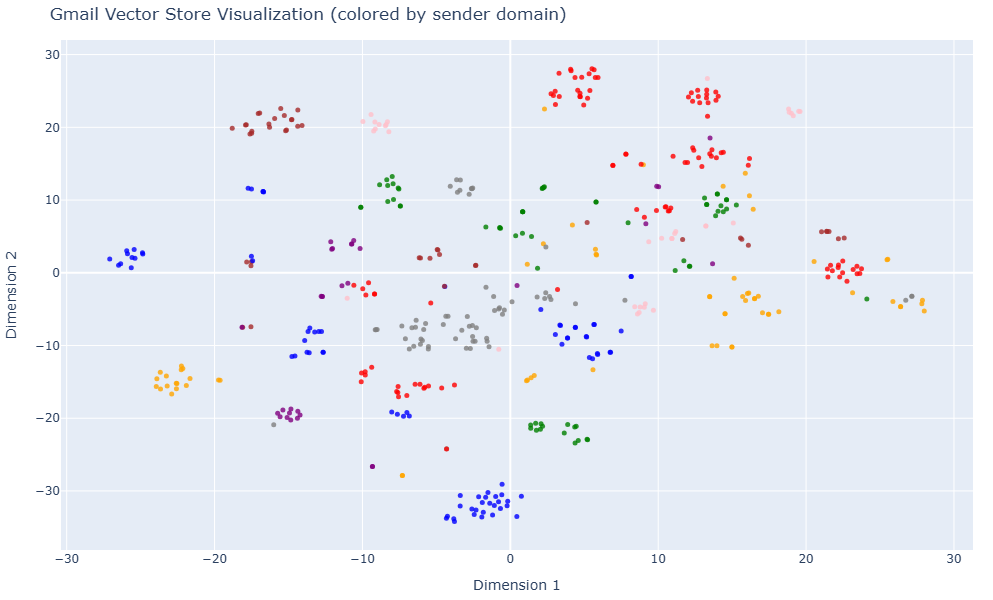

In [10]:
# Visualize the vector database
if vectorstore:
    print("Generating visualization...")
    fig = visualize_email_vectors(vectorstore)
    if fig:
        fig.show()
    else:
        print("⚠️  Visualization not available (insufficient data or error)")

In [11]:
# Set up the RAG conversation chain with error handling
def setup_conversation_chain(vectorstore):
    """Set up the conversation chain with appropriate LLM"""
    try:
        if LANGCHAIN_GOOGLE_AVAILABLE:
            llm = ChatGoogleGenerativeAI(model=MODEL, temperature=0.7)
            print("🧠 Using Gemini for conversations")
        else:
            llm = ChatOpenAI(model=MODEL, temperature=0.7)
            print("🧠 Using OpenAI for conversations")
        
        memory = ConversationBufferMemory(
            memory_key='chat_history', 
            return_messages=True, 
            output_key='answer'
        )
        
        retriever = vectorstore.as_retriever(search_kwargs={"k": 5})
        
        conversation_chain = ConversationalRetrievalChain.from_llm(
            llm=llm, 
            retriever=retriever, 
            memory=memory,
            return_source_documents=True
        )
        
        return conversation_chain
    except Exception as e:
        print(f"❌ Error setting up conversation chain: {e}")
        return None

# Initialize conversation chain
if vectorstore:
    conversation_chain = setup_conversation_chain(vectorstore)
    if conversation_chain:
        model_name = "Gemini" if LANGCHAIN_GOOGLE_AVAILABLE else "OpenAI"
        print(f"✅ RAG system ready with {model_name}!")
    else:
        print("❌ Failed to initialize conversation chain")
else:
    print("❌ No vector database available")
    conversation_chain = None

🧠 Using Gemini for conversations


C:\Users\manas\AppData\Local\Temp\ipykernel_32500\4025106116.py:12: LangChainDeprecationWarning:

Please see the migration guide at: https://python.langchain.com/docs/versions/migrating_memory/



✅ RAG system ready with Gemini!


In [12]:
def chat_with_emails(message, history):
    """Chat function for Gradio interface using LangChain"""
    if not conversation_chain:
        return "❌ RAG system not available. Please check your setup and API keys."
    
    try:
        # Simplify the message to avoid complex formatting that might cause issues
        result = conversation_chain.invoke({"question": message})
        answer = result['answer']
        
        # Add detailed source information
        if result.get('source_documents'):
            answer += "\n\n**📧 Email Sources:**\n"
            for i, doc in enumerate(result['source_documents'][:3]):  # Show top 3 sources
                subject = doc.metadata.get('subject', 'No Subject')
                sender = doc.metadata.get('sender', 'Unknown Sender')
                date = doc.metadata.get('date', 'Unknown Date')
                answer += f"\n{i+1}. \"{subject}\" from {sender} ({date})"
        
        return answer
    except Exception as e:
        error_msg = str(e)
        if "Unknown field for Part" in error_msg:
            return "❌ Gemini API formatting error. Try rephrasing your question or use simpler language."
        return f"❌ Error: {error_msg}\n💡 Try refreshing the interface or check your API keys."

In [13]:
# Launch the Gradio interface with error handling
if vectorstore and conversation_chain:
    model_name = "Gemini" if LANGCHAIN_GOOGLE_AVAILABLE else "OpenAI"
    print(f"🚀 Launching Gmail RAG interface with {model_name}...")
    
    interface = gr.ChatInterface(
        fn=chat_with_emails,
        type="messages",
        title=f"📧 Gmail RAG Assistant (LangChain + {model_name})",
        description=f"Ask questions about your Gmail emails. Powered by {model_name} AI, this system will search through your email history and provide intelligent answers based on your actual email content.",
        examples=[
            "What emails did I receive about work projects?",
            "Show me recent emails from my manager", 
            "What meeting invitations did I get this week?",
            "Find emails about travel plans",
            "What important announcements did I receive?",
            "Who sent me emails about deadlines?",
            "What were the main topics discussed in recent emails?"
        ],
        theme=gr.themes.Soft()
    )
    
    interface.launch(inbrowser=True)
else:
    print("❌ Gmail RAG system not available.")
    print("🔧 Please check:")
    print("   1. API keys are set correctly")
    print("   2. Dependencies are installed properly")
    print("   3. Gmail credentials are configured")

🚀 Launching Gmail RAG interface with Gemini...
* Running on local URL:  http://127.0.0.1:7867
* To create a public link, set `share=True` in `launch()`.


In [14]:
# System information and troubleshooting
def check_system_status():
    """Check system status and dependencies"""
    print("\n=== Gmail RAG System Status ===")
    print(f"🔧 LangChain Google GenAI Available: {LANGCHAIN_GOOGLE_AVAILABLE}")
    print(f"🤖 Using Model: {MODEL}")
    print(f"🔤 Using Embeddings: {EMBEDDING_MODEL}")
    print(f"💾 Database Path: {DB_NAME}")
    print(f"📊 Database Exists: {os.path.exists(DB_NAME)}")
    
    if vectorstore:
        print(f"📈 Vector Store Loaded: ✅")
        print(f"📧 Total Email Chunks: {vectorstore._collection.count()}")
    else:
        print(f"📈 Vector Store Loaded: ❌")
    
    # Check API keys
    google_key = os.environ.get('GOOGLE_API_KEY', '')
    openai_key = os.environ.get('OPENAI_API_KEY', '')
    
    print(f"🔑 Google API Key: {'✅' if google_key and google_key != 'your-key-if-not-using-env' else '❌'}")
    if not LANGCHAIN_GOOGLE_AVAILABLE:
        print(f"🔑 OpenAI API Key: {'✅' if openai_key and openai_key != 'your-key-if-not-using-env' else '❌'}")

# Run system check
check_system_status()

# Database statistics and management
def show_database_stats():
    """Show statistics about the email database"""
    if not collection:
        print("No vector database available")
        return
    
    result = collection.get(include=['metadatas'])
    
    print(f"\n=== Gmail RAG Database Statistics ===")
    print(f"Total chunks in database: {collection.count()}")
    
    # Analyze by sender
    senders = {}
    subjects = []
    
    for metadata in result['metadatas']:
        sender = metadata.get('sender', 'Unknown')
        subject = metadata.get('subject', 'No Subject')
        
        if sender in senders:
            senders[sender] += 1
        else:
            senders[sender] = 1
        
        if subject not in subjects:
            subjects.append(subject)
    
    print(f"Unique email subjects: {len(subjects)}")
    print(f"Top senders:")
    for sender, count in sorted(senders.items(), key=lambda x: x[1], reverse=True)[:10]:
        print(f"  {sender}: {count} chunks")

# Run statistics
if collection:
    show_database_stats()


=== Gmail RAG System Status ===
🔧 LangChain Google GenAI Available: True
🤖 Using Model: gemini-1.5-flash
🔤 Using Embeddings: models/embedding-001
💾 Database Path: gmail_vector_db
📊 Database Exists: True
📈 Vector Store Loaded: ✅
📧 Total Email Chunks: 495
🔑 Google API Key: ✅


NameError: name 'collection' is not defined